# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 2</a>

## Linear Regression Models and Regularization

In this notebook, we go over Linear Regression methods (with and without regularization: LinearRegression, Ridge, Lasso, ElasticNet) to predict the __log_votes__ field of our review dataset. 

1. <a href="#1">Reading the dataset</a>
2. <a href="#2">Exploratory data analysis</a>
3. <a href="#3">Stop word removal and stemming</a>
4. <a href="#4">Train - Validation Split</a>
5. <a href="#5">Data processing with Pipeline and ColumnTransform</a>
6. <a href="#6">Train the regressor</a>
7. <a href="#7">Fitting Linear Regression models and checking the validation performance</a> Find more details on the classical Linear Regression models with and without regularization here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
8. <a href="#8">Ideas for improvement</a>

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)


In [1]:
#Upgrade dependencies
!pip install --upgrade pip
!pip install --upgrade scikit-learn

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.2.4)
Requirement already up-to-date: scikit-learn in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (0.23.2)


## 1. <a name="1">Reading the dataset</a>
(<a href="#0">Go to top</a>)

We will use the __pandas__ library to read our dataset.

In [21]:
# import the datasets
import boto3
import os
from os import path
import pandas as pd

bucketname = 'mlu-courses-datalake' # replace with your bucket name
filename = 'MLA-NLP/data/examples/NLP-REVIEW-DATA-REGRESSION.csv' # replace with your object key
pathname = '../../data/examples'
s3 = boto3.resource('s3')
if not path.exists("../../data/examples"):
    try:
        os.makedirs(pathname)
    except OSError:
        print ("Creation of the directory %s failed" % path)

s3.Bucket(bucketname).download_file(filename, '../../data/examples/NLP-REVIEW-DATA-REGRESSION.csv')
print ("Successfully created the directory %s " % path)

Successfully created the directory <module 'posixpath' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/posixpath.py'> 


In [22]:
import pandas as pd

df = pd.read_csv('../../data/examples/NLP-REVIEW-DATA-REGRESSION.csv')
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

## 2. <a name="2">Exploratory data analysis</a>
(<a href="#0">Go to top</a>)

Let's look at the range and distribution of log_votes

In [5]:
df["log_votes"].min()

0.0

In [6]:
df["log_votes"].max()

7.799753318287247

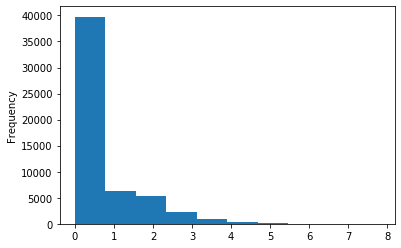

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [8]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


## 3. <a name="3">Text Processing: Stop words removal and stemming</a>
(<a href="#0">Go to top</a>)

In [9]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [10]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

## 4. <a name="4">Train - Validation Split</a>
(<a href="#0">Go to top</a>)

Let's split our dataset into training (90%) and validation (10%). We will use "reviewText", "summary", "time", "rating" fields and predict the "log_votes" field.

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "summary", "time", "rating"]],
                                                  df["log_votes"],
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

In [12]:
print("Processing the reviewText fields")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

print("Processing the summary fields")
X_train["summary"] = process_text(X_train["summary"].tolist())
X_val["summary"] = process_text(X_val["summary"].tolist())

Processing the reviewText fields
Processing the summary fields


Our __process_text()__ method in section 3 uses empty string for missing values.

## 5. <a name="5">Data processing with Pipeline and ColumnTransform</a>
(<a href="#0">Go to top</a>)

In the previous examples, we have seen how to use pipeline to prepare a data field for our machine learning model. This time, we will focus on multiple fields: numeric and text fields. We are using linear regression model from Sklearn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model. 

   * For the numerical features pipeline, the __numerical_processor__ below, we use a MinMaxScaler (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.
   * For the numerical features pipeline, the __text_processor__ below, we use CountVectorizer() for the text fields.
   
The selective preparations of the dataset features are then put together into a collective ColumnTransformer, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.

In [13]:
# Grab model features/inputs and target/output
numerical_features = ['time',
                      'rating']

text_features = ['summary',
                 'reviewText']

model_features = numerical_features + text_features
model_target = 'log_votes'

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_scaler', MinMaxScaler())
])
# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
]) 

### PIPELINE ###
################

# Pipeline desired all data transformers, along with an estimator at the end
# Later you can set/reach the parameters using the names issued - for hyperparameter tuning, for example
pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lr', LinearRegression())
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

## 6. <a name="6">Train the regressor</a>
(<a href="#0">Go to top</a>)

We train our model by using __.fit()__ on our training dataset. 

In [15]:
# Fit the Pipeline to training data
pipeline.fit(X_train[model_features], y_train.values)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical_pre',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['time', 'rating']),
                                                 ('text_pre_0',
                                                  Pipeline(steps=[('text_vect_0',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'summary'),
                                                 ('text_pre_1',
                                                  Pipeline(steps=[('text_vect_1',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'reviewText')])),
                ('lr', LinearRegression())])

## 7. <a name="7">Fitting Linear Regression models and checking the validation performance</a>
(<a href="#0">Go to top</a>)

#### 7.1  LinearRegression
Let's first fit __LinearRegression__ from Sklearn library, and check the performance on the validation dataset. Using the __coef___ atribute, we can also print the learned weights of the model.

Find more details on __LinearRegression__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lrRegressor_val_predictions = pipeline.predict(X_val[model_features])
print("LinearRegression on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lrRegressor_val_predictions),r2_score(y_val, lrRegressor_val_predictions)))
print("LinearRegression model weights: \n", pipeline.named_steps['lr'].coef_)

LinearRegression on Validation: Mean_squared_error: 0.591019,  R_square_score: 0.356071
LinearRegression model weights: 
 [-1.74590753e+00 -4.16827781e-01  6.56223816e-02 -2.36658291e-02
  8.60854427e-02 -9.27051260e-03  7.93510362e-02  9.70641826e-02
  5.27824843e-02  2.09907712e-02  5.79081832e-02  2.22186919e-01
  9.94181216e-02 -1.38870777e-02 -4.07029909e-02 -1.20768791e-04
  4.38411166e-02  9.08966669e-02  2.16030113e-02  1.30272252e-02
 -2.24451395e-02  8.60553810e-03  2.41577355e-02 -2.32745562e-02
 -3.29517519e-02 -9.95083726e-03 -1.51489295e-01 -3.76665562e-02
  6.48632395e-02 -1.17027209e-02  1.08722024e-02  1.58117204e-02
 -4.97168984e-02 -5.62027971e-02  5.82824695e-02 -8.74318501e-02
  1.69220359e-02 -4.06068295e-02  2.67460249e-02  4.64255610e-02
 -9.16061962e-03  1.16367946e-01  2.62843083e-02 -2.15540618e-02
 -1.20327888e-02 -4.01607065e-02 -5.44445140e-02 -1.19694699e-01
  1.22102019e-02  5.18642090e-02 -1.26616736e-02  8.86367186e-02
  5.44923883e-03 -4.71229042e-02 

#### 7.2  Ridge (Linear Regression with L2 regularization)
Let's now fit __Ridge__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Ridge__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

To improve the performance of a LinearRegression model, __Ridge__ is tuning model complexity by adding a $L_2$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  {alpha}∗||\textbf{w}||_2^2$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_2^2 = \sum \textbf{w}_i^2$.

The strength of the regularization is controlled by the regularizer parameter, alpha: smaller value of $alpha$, weaker regularization; larger value of $alpha$, stronger regularization. 


In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with Ridge regression model
ridge_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('ridge', Ridge(alpha = 100))
])

ridge_pipeline.fit(X_train[model_features], y_train.values)
ridgeRegressor_val_predictions = ridge_pipeline.predict(X_val[model_features])

print("Ridge on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, ridgeRegressor_val_predictions),r2_score(y_val, ridgeRegressor_val_predictions)))

print("Ridge model weights: \n", ridge_pipeline.named_steps['ridge'].coef_)

Ridge on Validation: Mean_squared_error: 0.589844,  R_square_score: 0.357352
Ridge model weights: 
 [-1.62635210e+00 -4.04848208e-01  5.76186079e-02 -2.26419500e-02
  7.78421623e-02 -9.88967848e-03  6.09623966e-02  8.11167165e-02
  4.38201670e-02  1.33631446e-02  4.95366609e-02  1.58831596e-01
  3.70352089e-02 -1.39015579e-02 -4.35834419e-02 -4.22894621e-03
  3.60617196e-02  7.39637476e-02  1.31996758e-02  4.04814517e-03
 -2.14134500e-02  1.18484237e-05  9.61147351e-03 -2.39121688e-02
 -3.26601998e-02 -9.78624635e-03 -1.23525044e-01 -6.95289794e-02
  5.39179239e-02 -8.34073347e-03  7.69029408e-03  1.12969994e-02
 -4.81731494e-02 -5.32981627e-02  5.13307325e-02 -4.78550422e-02
  1.85908185e-02 -4.23254662e-02 -2.57785716e-02  3.39920232e-02
 -1.15597563e-02  9.62148354e-02 -1.95906654e-02 -1.77413365e-02
 -1.37029486e-02 -3.38408127e-02 -5.07003714e-02 -8.67735820e-02
  6.78400680e-03  4.37206521e-02 -1.66840861e-02  7.71201323e-02
  5.07610693e-03 -4.86887355e-02  8.44192495e-02  6.310

#### 7.3 LASSO (Linear Regression with L1 regularization)
Let's also fit __Lasso__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __Lasso__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

__Lasso__ is tuning model complexity by adding a $L_1$ penalty score for complexity to the model cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  alpha∗||\textbf{w}||_1$$

where $\textbf{w}$ is the model weights vector, and $||\textbf{w}||_1 = \sum |\textbf{w}_i|$. 

Again, the strength of the regularization is controlled by the regularizer parameter, $alpha$. Due to the geometry of $L_1$ norm, with __Lasso__, some of the weights will shrink all the way to 0, leading to sparsity - some of the features are not contributing to the model afterall!

In [18]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with Lasso regression model
lasso_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('lasso', Lasso(alpha = 0.001))
])

lasso_pipeline.fit(X_train[model_features], y_train.values)
lassoRegressor_val_predictions = lasso_pipeline.predict(X_val[model_features])

print("Lasso on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, lassoRegressor_val_predictions),r2_score(y_val, lassoRegressor_val_predictions)))

print("Lasso model weights: \n", lasso_pipeline.named_steps['lasso'].coef_)

Lasso on Validation: Mean_squared_error: 0.589897,  R_square_score: 0.357293
Lasso model weights: 
 [-1.72018100e+00 -3.89042880e-01  2.58389442e-02 -0.00000000e+00
  3.82485970e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.10741687e-02  1.26495462e-01
  0.00000000e+00 -0.00000000e+00 -2.51506953e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.64845643e-02 -5.02203748e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.50588997e-02 -1.61126704e-02
  0.00000000e+00 -7.41813800e-03 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  1.96746839e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.42059517e-02
  0.00000000e+00 -1.67646076e-02  7.65653595e-02  5.118

#### 7.4 ElasticNet (Linear Regression with L2 and L1 regularization)
Let's finally try __ElasticNet__ from Sklearn library, and check the performance on the validation dataset.

Find more details on __ElasticNet__ here:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

__ElasticNet__ is tuning model complexity by adding both $L_2$ and $L_1$ penalty scores for complexity to the model's cost function:

$$\text{C}_{\text{regularized}}(\textbf{w}) = \text{C}(\textbf{w}) +  0.5*alpha∗(1-\textit{l1}_{ratio})||\textbf{w}||_2^2 + alpha∗\textit{l1}_{ratio}∗||\textbf{w}||_1$$

and using two parameters, $alpha$ and $\textit{l1}_{ratio}$, to control the strength of the regularization.

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# Let's update the pipeline with ElasticNet regression model
elastic_net_pipeline = Pipeline([
    ('data_preprocessing', data_preprocessor),
    ('elastic_net', ElasticNet(alpha = 0.001, l1_ratio = 0.1))
])

elastic_net_pipeline.fit(X_train[model_features], y_train.values)
enRegressor_val_predictions = elastic_net_pipeline.predict(X_val[model_features])

print("ElasticNet on Validation: Mean_squared_error: %f,  R_square_score: %f" % \
      (mean_squared_error(y_val, enRegressor_val_predictions),r2_score(y_val, enRegressor_val_predictions)))

print("ElasticNet model weights: \n", elastic_net_pipeline.named_steps['elastic_net'].coef_)

ElasticNet on Validation: Mean_squared_error: 0.589985,  R_square_score: 0.357198
ElasticNet model weights: 
 [-1.68718222e+00 -4.07740028e-01  5.81308220e-02 -1.75564911e-02
  7.70591086e-02 -2.02403237e-03  6.08587250e-02  7.94764703e-02
  3.99381579e-02  1.26925348e-02  4.95580421e-02  1.81298075e-01
  5.73046718e-02 -7.59518266e-03 -4.03917952e-02 -4.27928483e-04
  3.30656546e-02  7.27641740e-02  1.02780896e-02  1.83194721e-03
 -1.69492775e-02  0.00000000e+00  5.33213698e-03 -1.74826824e-02
 -2.70392602e-02 -7.14594014e-03 -1.27054861e-01 -5.45432203e-02
  5.14365668e-02 -8.54135047e-04  7.64116064e-03  9.84371469e-03
 -4.33614666e-02 -4.76031350e-02  5.30067486e-02 -6.00945802e-02
  1.05994151e-02 -4.03642004e-02 -0.00000000e+00  3.00438757e-02
 -2.45581424e-03  9.73759228e-02 -0.00000000e+00 -1.09435272e-02
 -8.14249497e-03 -2.81622915e-02 -4.78513573e-02 -8.48689257e-02
  0.00000000e+00  4.10798809e-02 -1.24165904e-02  7.47455651e-02
  4.32150583e-03 -4.46213628e-02  8.62062915e

#### 7.5 Weights shrinkage and sparsity

Let's compare weights ranges for all these regression models:

In [20]:
import numpy as np

lin_regression_coeffs = pipeline.named_steps['lr'].coef_
ridge_regression_coeffs = ridge_pipeline.named_steps['ridge'].coef_
lasso_regression_coeffs = lasso_pipeline.named_steps['lasso'].coef_
enet_regression_coeffs = elastic_net_pipeline.named_steps['elastic_net'].coef_

print('LinearRegression weights range: \n', np.abs(lin_regression_coeffs).min(), np.abs(lin_regression_coeffs).max())
print('Ridge weights range: \n', np.abs(ridge_regression_coeffs).min(), np.abs(ridge_regression_coeffs).max())
print('Lasso weights range: \n', np.abs(lasso_regression_coeffs).min(), np.abs(lasso_regression_coeffs).max())
print('ElasticNet weights range: \n', np.abs(enet_regression_coeffs).min(), np.abs(enet_regression_coeffs).max())

LinearRegression weights range: 
 3.9519150249327546e-05 1.7459075251306901
Ridge weights range: 
 1.184842373648761e-05 1.6263521023373955
Lasso weights range: 
 0.0 1.720181000769515
ElasticNet weights range: 
 0.0 1.687182215447088


The weights of all regularized models are lowered compared to __LinearRegression__, with some of the weights of __Lasso__ and __ElasticNet__ shrinked all the way to 0. Using sparsity, the __Lasso__ regularization reduces the number of features, performing feature selection.

## 8. <a name="7">Ideas for improvement</a>
(<a href="#0">Go to top</a>)

One way to improve the performance of a linear regression model is to try different strenghts of regularization, here controlled by the parameters $alpha$ and $\textit{l1}_{ratio}$.